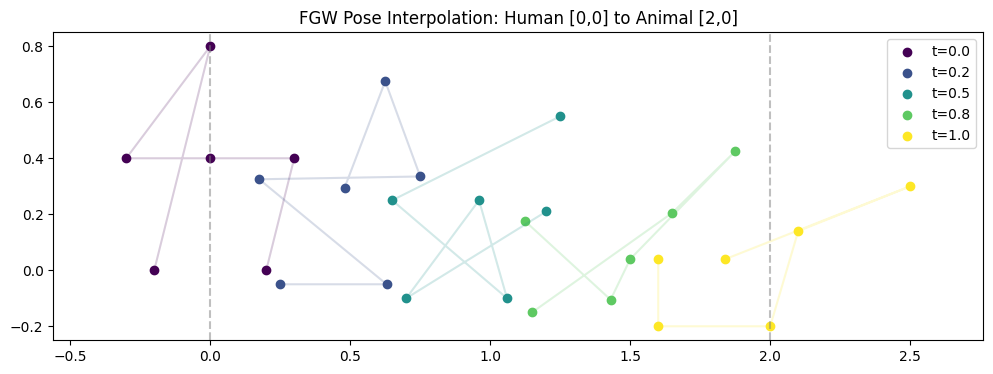

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from ot.gromov import fgw_barycenters
from scipy.spatial.distance import cdist

def get_interpolants(human_coords, animal_coords, n_steps=5):
    # Setup
    C1 = cdist(human_coords, human_coords, metric='sqeuclidean')
    C2 = cdist(animal_coords, animal_coords, metric='sqeuclidean')
    C1 /= C1.max(); C2 /= C2.max()
    
    p1, p2 = ot.unif(len(human_coords)), ot.unif(len(animal_coords))
    n_nodes = max(len(human_coords), len(animal_coords))
    p_bary = ot.unif(n_nodes)
    
    steps = np.linspace(0, 1, n_steps)
    results = []

    for t in steps:
        weights = np.array([1 - t, t])
        # Solve for the hybrid "feature" (coordinates) and "structure" (connectivity)
        X_t, _ = fgw_barycenters(n_nodes, [human_coords, animal_coords], 
                                 [C1, C2], [p1, p2], weights, 
                                 alpha=0.5, p=p_bary, max_iter=100)
        
        # Shift X coordinate for the horizontal layout (0 to 2)
        X_t[:, 0] += t * 2
        results.append(X_t)
    return results

# Define simplified 2D poses (Humanoid vs Quadruped)
human = np.array([[0, 0.8], [0, 0.4], [-0.3, 0.4], [0.3, 0.4], [-0.2, 0], [0.2, 0]]) # Head, Spine, Arms, Legs
animal = np.array([[0.5, 0.3], [0, 0.1], [-0.4, 0.1], [-0.4, -0.2], [0, -0.2]]) # Head, Body, Tail, Back-Legs

# Calculate Interpolants
n_interpolates = 5
interpolants = get_interpolants(human, animal, n_steps=n_interpolates)

# Plotting
plt.figure(figsize=(12, 4))
colors = plt.cm.viridis(np.linspace(0, 1, n_interpolates))

for i, pts in enumerate(interpolants):
    plt.scatter(pts[:, 0], pts[:, 1], color=colors[i], label=f"t={i/(n_interpolates-1):.1f}")
    # Draw simple hull or connectivity if desired, here we just show nodes
    plt.plot(pts[:, 0], pts[:, 1], alpha=0.2, color=colors[i])

plt.title("FGW Pose Interpolation: Human [0,0] to Animal [2,0]")
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=2, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.axis('equal')
plt.show()


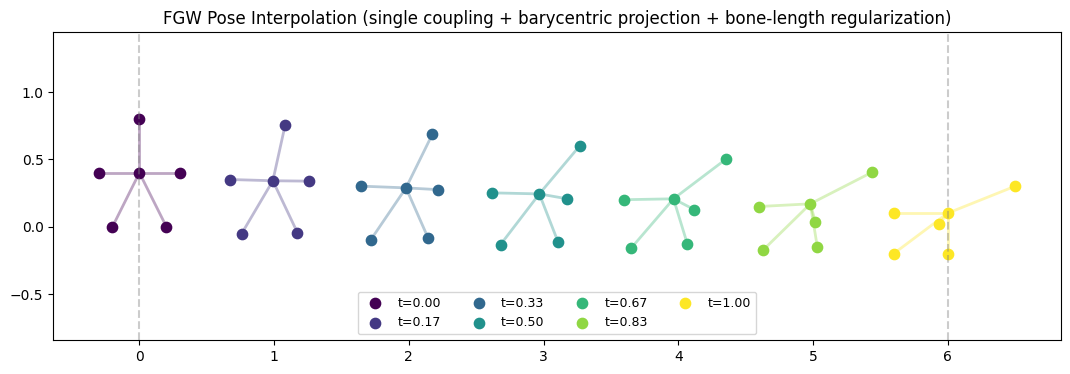

In [15]:
# One-cell, refactor-friendly pose interpolation via Fused Gromov-Wasserstein (FGW)
# - Works when skeletons have different node counts/topologies
# - Produces a sequence of interpolated poses in a chosen output skeleton's representation (default: source skeleton)
# - Includes optional "position-based dynamics" (PBD) bone-length regularization for nicer mid-poses

import numpy as np
import matplotlib.pyplot as plt
import ot
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
from scipy.spatial.distance import cdist

# -----------------------------
# Core data structure
# -----------------------------
@dataclass
class PoseGraph:
    coords: np.ndarray                      # (n, d) where d=2 or 3
    edges: List[Tuple[int, int]]            # undirected bones
    conf: Optional[np.ndarray] = None       # (n,) confidence/weights; <=0 or nan => invalid
    labels: Optional[List[str]] = None      # (n,) joint names/types; optional but very useful later (OpenPose)
    name: str = "pose"

    def copy(self):
        return PoseGraph(
            coords=np.array(self.coords, copy=True),
            edges=list(self.edges),
            conf=None if self.conf is None else np.array(self.conf, copy=True),
            labels=None if self.labels is None else list(self.labels),
            name=self.name,
        )

# -----------------------------
# Utilities
# -----------------------------
def _valid_mask(coords: np.ndarray, conf: Optional[np.ndarray]) -> np.ndarray:
    ok = np.all(np.isfinite(coords), axis=1)
    if conf is not None:
        ok = ok & np.isfinite(conf) & (conf > 0)
    return ok

def compact_pose(p: PoseGraph) -> Tuple[PoseGraph, np.ndarray]:
    """Drop invalid joints (nan/inf or conf<=0) and reindex edges accordingly."""
    coords = np.asarray(p.coords, dtype=float)
    conf = None if p.conf is None else np.asarray(p.conf, dtype=float)

    mask = _valid_mask(coords, conf)
    idx = np.where(mask)[0]
    if len(idx) < 2:
        raise ValueError(f"{p.name}: not enough valid joints after filtering (got {len(idx)}).")

    old_to_new = -np.ones(coords.shape[0], dtype=int)
    old_to_new[idx] = np.arange(len(idx))

    new_edges = []
    for a, b in p.edges:
        if 0 <= a < len(old_to_new) and 0 <= b < len(old_to_new):
            na, nb = old_to_new[a], old_to_new[b]
            if na >= 0 and nb >= 0 and na != nb:
                new_edges.append((int(na), int(nb)))

    new_conf = None if conf is None else conf[idx]
    new_labels = None if p.labels is None else [p.labels[i] for i in idx]

    # Deduplicate edges (undirected)
    dedup = set()
    clean_edges = []
    for a, b in new_edges:
        u, v = (a, b) if a < b else (b, a)
        if (u, v) not in dedup:
            dedup.add((u, v))
            clean_edges.append((u, v))

    return PoseGraph(coords=coords[idx], edges=clean_edges, conf=new_conf, labels=new_labels, name=p.name), idx

def compute_center_scale(coords: np.ndarray, edges: List[Tuple[int,int]]) -> Tuple[np.ndarray, float]:
    """Center = mean; Scale = median bone length (robust). Falls back to RMS radius."""
    c = np.nanmean(coords, axis=0)
    x = coords - c
    lengths = []
    for i, j in edges:
        if 0 <= i < len(coords) and 0 <= j < len(coords):
            li = np.linalg.norm(coords[i] - coords[j])
            if np.isfinite(li) and li > 0:
                lengths.append(li)
    if len(lengths) > 0:
        s = float(np.median(lengths))
    else:
        r = np.sqrt(np.nanmean(np.sum(x**2, axis=1)))
        s = float(r) if np.isfinite(r) and r > 0 else 1.0
    if s <= 0 or not np.isfinite(s):
        s = 1.0
    return c, s

def canonicalize(coords: np.ndarray, edges: List[Tuple[int,int]]) -> Tuple[np.ndarray, np.ndarray, float]:
    """Return coords in a shared canonical frame: centered, scale-normalized."""
    c, s = compute_center_scale(coords, edges)
    return (coords - c) / s, c, s

def floyd_warshall(dist: np.ndarray) -> np.ndarray:
    """Vectorized Floyd–Warshall; dist is (n,n)."""
    d = dist.copy()
    n = d.shape[0]
    for k in range(n):
        d = np.minimum(d, d[:, [k]] + d[[k], :])
    return d

def structural_cost_matrix(coords: np.ndarray,
                           edges: List[Tuple[int,int]],
                           mode: str = "unweighted") -> np.ndarray:
    """
    Build C (n,n) for FGW's structure term.
    mode:
      - 'unweighted': each bone has weight 1 (pure topology)
      - 'bone_length': bone weights = current Euclidean length (pose-dependent)
    """
    n = coords.shape[0]
    inf = 1e9
    D = np.full((n, n), inf, dtype=float)
    np.fill_diagonal(D, 0.0)
    for i, j in edges:
        if mode == "bone_length":
            w = float(np.linalg.norm(coords[i] - coords[j]))
            if not np.isfinite(w) or w <= 0:
                w = 1.0
        else:
            w = 1.0
        D[i, j] = min(D[i, j], w)
        D[j, i] = min(D[j, i], w)

    D = floyd_warshall(D)

    # Replace unreachable pairs with a large finite value
    finite = D[np.isfinite(D) & (D < inf)]
    if finite.size == 0:
        D = np.zeros((n, n), dtype=float)
    else:
        big = float(np.max(finite)) * 1.25
        D[~np.isfinite(D) | (D >= inf)] = big

    # Normalize to [0,1] for numeric stability
    mx = float(np.max(D))
    if mx > 0:
        D = D / mx
    return D

def label_cost(labels_a: Optional[List[str]], labels_b: Optional[List[str]]) -> Optional[np.ndarray]:
    """0 if same label else 1. Returns None if labels missing."""
    if labels_a is None or labels_b is None:
        return None
    la = np.array(labels_a, dtype=object)[:, None]
    lb = np.array(labels_b, dtype=object)[None, :]
    return (la != lb).astype(float)

def safe_prob_weights(n: int, conf: Optional[np.ndarray]) -> np.ndarray:
    if conf is None:
        w = np.ones(n, dtype=float)
    else:
        w = np.asarray(conf, dtype=float).copy()
        w[~np.isfinite(w)] = 0.0
        w[w < 0] = 0.0
        if np.all(w == 0):
            w[:] = 1.0
    w = w / np.sum(w)
    # POT is happier with strictly positive weights
    eps = 1e-12
    w = np.maximum(w, eps)
    w = w / np.sum(w)
    return w

def fgw_coupling(Xa: np.ndarray, Ca: np.ndarray, pa: np.ndarray,
                 Xb: np.ndarray, Cb: np.ndarray, pb: np.ndarray,
                 alpha: float = 0.5,
                 w_pos: float = 1.0,
                 w_label: float = 0.5,
                 labels_a: Optional[List[str]] = None,
                 labels_b: Optional[List[str]] = None,
                 max_iter: int = 200,
                 tol: float = 1e-9,
                 verbose: bool = False) -> np.ndarray:
    """
    Compute FGW coupling pi between nodes of a and b.
    POT's fused GW objective blends feature cost M and structure (GW) via alpha.
    """
    # Feature cost: squared euclidean in canonical space
    M = cdist(Xa, Xb, metric="sqeuclidean")
    if M.size > 0:
        mmax = float(np.max(M))
        if mmax > 0:
            M = M / mmax

    # Optional label mismatch cost
    L = label_cost(labels_a, labels_b)
    if L is not None:
        M = (w_pos * M + w_label * L) / (w_pos + w_label)
        mmax = float(np.max(M))
        if mmax > 0:
            M = M / mmax

    # POT API is stable: ot.gromov.fused_gromov_wasserstein(...)
    try:
        pi, log = ot.gromov.fused_gromov_wasserstein(
            M, Ca, Cb, pa, pb, loss_fun="square_loss",
            alpha=float(alpha), armijo=True, log=True,
            max_iter=max_iter, tol_rel=tol, tol_abs=tol, verbose=verbose
        )
        return pi
    except TypeError:
        # fallback for older signatures
        pi, log = ot.gromov.fused_gromov_wasserstein(
            M, Ca, Cb, pa, pb, loss_fun="square_loss",
            alpha=float(alpha), armijo=True, log=True
        )
        return pi

def barycentric_projection(pi: np.ndarray, Xb: np.ndarray, pa: np.ndarray) -> np.ndarray:
    """
    Map each node in a to a weighted average of nodes in b:
        T_a->b(i) = sum_j pi_ij * Xb_j / pa_i
    """
    denom = np.maximum(pa, 1e-12)[:, None]
    P = pi / denom
    return P @ Xb

def pbd_enforce_bone_lengths(X: np.ndarray,
                            edges: List[Tuple[int,int]],
                            target_lengths: np.ndarray,
                            iters: int = 20,
                            stiffness: float = 0.8) -> np.ndarray:
    """
    Simple Position-Based Dynamics length projection.
    target_lengths is (len(edges),).
    """
    if iters <= 0 or len(edges) == 0:
        return X
    Y = X.copy()
    for _ in range(iters):
        for e_idx, (i, j) in enumerate(edges):
            xi, xj = Y[i], Y[j]
            v = xj - xi
            d = float(np.linalg.norm(v))
            if not np.isfinite(d) or d < 1e-12:
                continue
            L = float(target_lengths[e_idx])
            if not np.isfinite(L) or L <= 0:
                continue
            # Move both endpoints to satisfy length constraint
            diff = (d - L) / d
            corr = 0.5 * stiffness * diff * v
            Y[i] += corr
            Y[j] -= corr
    return Y

def pack_openpose_keypoints(coords_xy: np.ndarray,
                            conf: Optional[np.ndarray] = None,
                            fill_conf: float = 1.0) -> np.ndarray:
    """
    Pack (n,2) -> (3n,) [x1,y1,c1,x2,y2,c2,...]. This matches the common OpenPose keypoint layout.
    (If you're using Body_25, n=25.)
    """
    n = coords_xy.shape[0]
    out = np.zeros((n, 3), dtype=float)
    out[:, :2] = coords_xy[:, :2]
    if conf is None:
        out[:, 2] = float(fill_conf)
    else:
        c = np.asarray(conf, dtype=float)
        c[~np.isfinite(c)] = 0.0
        out[:, 2] = c
    return out.reshape(-1)

# -----------------------------
# Main interpolation
# -----------------------------
def interpolate_pose_graphs(
    pose_a: PoseGraph,
    pose_b: PoseGraph,
    n_steps: int = 7,
    alpha: float = 0.55,
    structure_mode: str = "unweighted",
    pbd_iters: int = 25,
    pbd_stiffness: float = 0.85,
    use_labels: bool = True,
    w_pos: float = 1.0,
    w_label: float = 0.75,
    output_template: str = "a",          # "a" or "b" (choose which skeleton topology/indexing to output)
    return_openpose_flat: bool = False,  # pack each interpolant into OpenPose-like (3n,) vector
    verbose: bool = False,
) -> Dict[str, object]:
    """
    Interpolate between poses using a single FGW coupling + barycentric projection.
    Output is a sequence of poses expressed in the chosen template skeleton's nodes/edges.

    Returns a dict with:
      - 'ts': (n_steps,) times
      - 'poses': list of (n_template, d) arrays (in global-ish coordinates interpolated between A/B)
      - 'poses_flat' (optional): list of (3*n_template,) packed vectors
      - 'template': PoseGraph (compacted)
      - 'pi': coupling matrix between compacted A and B
      - 'remap': info to lift compacted back to original indices
    """
    if n_steps < 2:
        raise ValueError("n_steps must be >= 2")

    # Compact (drop invalid joints) but keep maps for lifting back if you want later
    A, idxA = compact_pose(pose_a)
    B, idxB = compact_pose(pose_b)

    # Canonicalize both into the same coordinate frame (centered & scaled independently)
    XA, cA, sA = canonicalize(A.coords, A.edges)
    XB, cB, sB = canonicalize(B.coords, B.edges)

    # Structure matrices (in canonical coords; topology mostly comes from edges)
    CA = structural_cost_matrix(XA, A.edges, mode=structure_mode)
    CB = structural_cost_matrix(XB, B.edges, mode=structure_mode)

    # Node weights (probabilities)
    pa = safe_prob_weights(len(XA), A.conf)
    pb = safe_prob_weights(len(XB), B.conf)

    # Optional labels
    la = A.labels if (use_labels and A.labels is not None) else None
    lb = B.labels if (use_labels and B.labels is not None) else None

    # FGW coupling
    pi = fgw_coupling(
        XA, CA, pa,
        XB, CB, pb,
        alpha=alpha,
        w_pos=w_pos,
        w_label=w_label,
        labels_a=la,
        labels_b=lb,
        max_iter=300,
        tol=1e-9,
        verbose=verbose,
    )

    # Choose which skeleton we output in
    if output_template.lower() == "b":
        template = B
        X_template = XB
        c_template, s_template = cB, sB
        # project B->A then interpolate in B's indexing by projecting A into B
        # Use pi^T as coupling from B to A, with pb
        XA_hat_on_B = barycentric_projection(pi.T, XA, pb)  # B-nodes live in canonical, mapped towards A
        X0 = XB
        X1 = XA_hat_on_B
        edges = B.edges
        # lift map: which original indices correspond to compacted template nodes
        lift_idx = idxB
    else:
        template = A
        X_template = XA
        c_template, s_template = cA, sA
        XB_hat_on_A = barycentric_projection(pi, XB, pa)    # A-nodes mapped towards B in canonical space
        X0 = XA
        X1 = XB_hat_on_A
        edges = A.edges
        lift_idx = idxA

    # Bone-length targets for PBD: interpolate between lengths at X0 and X1
    def edge_lengths(X, edges):
        L = []
        for i, j in edges:
            L.append(float(np.linalg.norm(X[i] - X[j])))
        return np.array(L, dtype=float) if len(L) else np.zeros((0,), dtype=float)

    L0 = edge_lengths(X0, edges)
    L1 = edge_lengths(X1, edges)

    ts = np.linspace(0.0, 1.0, n_steps)
    poses = []
    poses_flat = []

    # Global-ish transform interpolation:
    # Because we canonicalized both independently, we re-embed with interpolated center/scale between A and B.
    # This gives reasonable behavior when A and B come from different absolute coordinate frames.
    c_global = (1 - ts)[:, None] * cA[None, :] + ts[:, None] * cB[None, :]
    s_global = (1 - ts) * sA + ts * sB

    for k, t in enumerate(ts):
        # Interpolate in canonical space (template nodes)
        Xt = (1 - t) * X0 + t * X1

        # Optional bone-length regularization
        if pbd_iters > 0 and len(edges) > 0:
            Lt = (1 - t) * L0 + t * L1
            Xt = pbd_enforce_bone_lengths(Xt, edges, Lt, iters=pbd_iters, stiffness=pbd_stiffness)

        # Re-embed into a blended global coordinate frame
        Xt_global = Xt * s_global[k] + c_global[k]
        poses.append(Xt_global)

        if return_openpose_flat:
            poses_flat.append(pack_openpose_keypoints(Xt_global[:, :2], conf=template.conf))

    out = {
        "ts": ts,
        "poses": poses,
        "template": template,
        "pi": pi,
        "remap": {
            "output_template": output_template.lower(),
            "template_compacted_indices_in_original": lift_idx,
            "a_compacted_indices_in_original": idxA,
            "b_compacted_indices_in_original": idxB,
        },
    }
    if return_openpose_flat:
        out["poses_flat"] = poses_flat
    return out

# -----------------------------
# Demo (your toy human vs animal, but with explicit bones + better plotting)
# -----------------------------
human = PoseGraph(
    coords=np.array([
        [0.0, 0.8],   # 0 head
        [0.0, 0.4],   # 1 spine
        [-0.3, 0.4],  # 2 l_arm
        [0.3, 0.4],   # 3 r_arm
        [-0.2, 0.0],  # 4 l_leg
        [0.2, 0.0],   # 5 r_leg
    ], dtype=float),
    edges=[(0,1),(1,2),(1,3),(1,4),(1,5)],
    labels=["head","spine","l_arm","r_arm","l_leg","r_leg"],
    name="human",
)

animal = PoseGraph(
    coords=np.array([
        [0.5, 0.3],   # 0 head
        [0.0, 0.1],   # 1 body
        [-0.4, 0.1],  # 2 tail
        [-0.4,-0.2],  # 3 back_leg_1
        [0.0,-0.2],   # 4 back_leg_2
    ], dtype=float),
    edges=[(0,1),(1,2),(1,3),(1,4)],
    labels=["head","body","tail","back_leg","back_leg"],
    name="animal",
)

res = interpolate_pose_graphs(
    human, animal,
    n_steps=7,
    alpha=0.60,                 # more structure weight = more topology-aware matching
    structure_mode="unweighted",
    pbd_iters=35,
    pbd_stiffness=0.85,
    use_labels=True,
    w_pos=1.0,
    w_label=0.8,
    output_template="a",        # output in human node indexing (later: OpenPose indexing)
    return_openpose_flat=False,
    verbose=False,
)

# Plot sequence with a horizontal layout shift for readability (does NOT affect returned poses)
ts = res["ts"]
poses = res["poses"]
edges = res["template"].edges

plt.figure(figsize=(13, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(poses)))
x_shift = 6.0  # shift amount for visualization only

for k, (t, X) in enumerate(zip(ts, poses)):
    Xp = X.copy()
    Xp[:, 0] += t * x_shift

    # edges
    for (i, j) in edges:
        plt.plot([Xp[i,0], Xp[j,0]], [Xp[i,1], Xp[j,1]], color=colors[k], alpha=0.35, linewidth=2)

    # joints
    plt.scatter(Xp[:, 0], Xp[:, 1], color=colors[k], s=55, label=f"t={t:.2f}")

plt.title("FGW Pose Interpolation (single coupling + barycentric projection + bone-length regularization)")
plt.axvline(x=0, color="gray", linestyle="--", alpha=0.4)
plt.axvline(x=x_shift, color="gray", linestyle="--", alpha=0.4)
plt.axis("equal")
plt.legend(ncol=4, fontsize=9)
plt.show()

# Your interpolated poses are now in:
#   res["poses"]          -> list of (n_template, 2) arrays
# And if you set return_openpose_flat=True (and n_template==OpenPose joint count):
#   res["poses_flat"]     -> list of (3*n_template,) vectors [x,y,conf,...]


In [16]:
import sys, subprocess, os, glob



In [17]:
import os, json, math, glob, subprocess
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys, subprocess, os, glob


# ============
# Notes / citations baked into logic:
# - MMPoseInferencer API supports det_model, det_weights, det_cat_ids, and whole_image mode. (Docs)
# - AP-10K keypoint order is fixed (we map it into OpenPose COCO-18).
# - Output format matches OpenPose JSON: people[0].pose_keypoints_2d = [x,y,score]*18
# ============

# ----------------------------
# Canonical target: OpenPose COCO-18 order
# 0 nose, 1 neck, 2 r_sh, 3 r_el, 4 r_wr, 5 l_sh, 6 l_el, 7 l_wr,
# 8 r_hip, 9 r_kn, 10 r_an, 11 l_hip, 12 l_kn, 13 l_an,
# 14 r_eye, 15 l_eye, 16 r_ear, 17 l_ear
# ----------------------------
OP18 = {
    "nose":0,"neck":1,
    "r_shoulder":2,"r_elbow":3,"r_wrist":4,
    "l_shoulder":5,"l_elbow":6,"l_wrist":7,
    "r_hip":8,"r_knee":9,"r_ankle":10,
    "l_hip":11,"l_knee":12,"l_ankle":13,
    "r_eye":14,"l_eye":15,"r_ear":16,"l_ear":17
}

# OpenPose-ish skeleton edges (tree-ish) for bone projection
OP18_EDGES = [
    (OP18["neck"], OP18["nose"]),
    (OP18["nose"], OP18["r_eye"]),
    (OP18["r_eye"], OP18["r_ear"]),
    (OP18["nose"], OP18["l_eye"]),
    (OP18["l_eye"], OP18["l_ear"]),
    (OP18["neck"], OP18["r_shoulder"]),
    (OP18["r_shoulder"], OP18["r_elbow"]),
    (OP18["r_elbow"], OP18["r_wrist"]),
    (OP18["neck"], OP18["l_shoulder"]),
    (OP18["l_shoulder"], OP18["l_elbow"]),
    (OP18["l_elbow"], OP18["l_wrist"]),
    (OP18["neck"], OP18["r_hip"]),
    (OP18["r_hip"], OP18["r_knee"]),
    (OP18["r_knee"], OP18["r_ankle"]),
    (OP18["neck"], OP18["l_hip"]),
    (OP18["l_hip"], OP18["l_knee"]),
    (OP18["l_knee"], OP18["l_ankle"]),
]

def _ensure_dir(p): os.makedirs(p, exist_ok=True)

def mim_download(package: str, config_name: str, dest_dir: str):
    os.makedirs(dest_dir, exist_ok=True)
    cmd = [sys.executable, "-m", "mim", "download", package, "--config", config_name, "--dest", dest_dir]
    print(">>", " ".join(cmd))
    subprocess.run(cmd, check=True)

    py = os.path.join(dest_dir, f"{config_name}.py")
    if not os.path.exists(py):
        hits = glob.glob(os.path.join(dest_dir, "**", f"{config_name}.py"), recursive=True)
        if hits: py = hits[0]

    pths = glob.glob(os.path.join(dest_dir, f"{config_name}*.pth"))
    if not pths:
        pths = glob.glob(os.path.join(dest_dir, "**", f"{config_name}*.pth"), recursive=True)
    if not pths:
        raise FileNotFoundError(f"Could not find checkpoint for {config_name} under {dest_dir}")
    ckpt = sorted(pths, key=len)[0]
    return py, ckpt

def pick_best_instance(pred_list):
    """pred_list: list[dict] for each detected instance (MMPose inferencer output)."""
    if not pred_list:
        return None
    best = None
    best_score = -1
    for inst in pred_list:
        ks = np.array(inst.get("keypoint_scores", []), dtype=float)
        if ks.size == 0:
            continue
        s = float(np.nanmean(ks))
        if s > best_score:
            best_score = s
            best = inst
    return best

def coco17_to_op18(coco_kpts_xy: np.ndarray, coco_scores: np.ndarray):
    """
    COCO-17 order (standard):
    0 nose,
    1 l_eye,2 r_eye,3 l_ear,4 r_ear,
    5 l_sh,6 r_sh,7 l_el,8 r_el,9 l_wr,10 r_wr,
    11 l_hip,12 r_hip,13 l_kn,14 r_kn,15 l_an,16 r_an
    """
    k = np.zeros((18,3), dtype=float)

    def set_op(op_idx, coco_idx):
        k[op_idx,0:2] = coco_kpts_xy[coco_idx]
        k[op_idx,2]   = coco_scores[coco_idx]

    set_op(OP18["nose"], 0)
    # neck = midpoint of shoulders
    lsh, rsh = 5, 6
    neck_xy = (coco_kpts_xy[lsh] + coco_kpts_xy[rsh]) / 2.0
    neck_sc = (coco_scores[lsh] + coco_scores[rsh]) / 2.0
    k[OP18["neck"],0:2] = neck_xy
    k[OP18["neck"],2]   = neck_sc

    # right side (OpenPose uses right=subject's right)
    set_op(OP18["r_shoulder"], 6)
    set_op(OP18["r_elbow"], 8)
    set_op(OP18["r_wrist"], 10)
    set_op(OP18["r_hip"], 12)
    set_op(OP18["r_knee"], 14)
    set_op(OP18["r_ankle"], 16)

    # left side
    set_op(OP18["l_shoulder"], 5)
    set_op(OP18["l_elbow"], 7)
    set_op(OP18["l_wrist"], 9)
    set_op(OP18["l_hip"], 11)
    set_op(OP18["l_knee"], 13)
    set_op(OP18["l_ankle"], 15)

    # face
    set_op(OP18["l_eye"], 1)
    set_op(OP18["r_eye"], 2)
    set_op(OP18["l_ear"], 3)
    set_op(OP18["r_ear"], 4)

    return k

def ap10k17_to_op18(ap_kpts_xy: np.ndarray, ap_scores: np.ndarray):
    """
    AP-10K 17 keypoints (MMPose doc/code order):
    0 L_Eye, 1 R_Eye, 2 Nose, 3 Neck, 4 TailRoot,
    5 L_Shoulder,6 L_Elbow,7 L_F_Paw,
    8 R_Shoulder,9 R_Elbow,10 R_F_Paw,
    11 L_Hip,12 L_Knee,13 L_B_Paw,
    14 R_Hip,15 R_Knee,16 R_B_Paw
    (We map paws to wrists/ankles. Ears are approximated.)
    """
    k = np.zeros((18,3), dtype=float)

    def set_op(op_idx, ap_idx):
        k[op_idx,0:2] = ap_kpts_xy[ap_idx]
        k[op_idx,2]   = ap_scores[ap_idx]

    set_op(OP18["nose"], 2)
    set_op(OP18["neck"], 3)

    # shoulders/elbows/paws -> shoulders/elbows/wrists
    set_op(OP18["l_shoulder"], 5)
    set_op(OP18["l_elbow"], 6)
    set_op(OP18["l_wrist"], 7)

    set_op(OP18["r_shoulder"], 8)
    set_op(OP18["r_elbow"], 9)
    set_op(OP18["r_wrist"], 10)

    # hips/knees/back paws -> hips/knees/ankles
    set_op(OP18["l_hip"], 11)
    set_op(OP18["l_knee"], 12)
    set_op(OP18["l_ankle"], 13)

    set_op(OP18["r_hip"], 14)
    set_op(OP18["r_knee"], 15)
    set_op(OP18["r_ankle"], 16)

    # eyes
    set_op(OP18["l_eye"], 0)
    set_op(OP18["r_eye"], 1)

    # approximate ears (AP-10K doesn't provide them)
    # If eyes/neck are present, place ears above and slightly lateral from eyes.
    le, re, neck = k[OP18["l_eye"],:2], k[OP18["r_eye"],:2], k[OP18["neck"],:2]
    le_s, re_s, n_s = k[OP18["l_eye"],2], k[OP18["r_eye"],2], k[OP18["neck"],2]
    eye_mid = (le + re) / 2.0
    v = eye_mid - neck
    v_norm = np.linalg.norm(v) + 1e-9
    v = v / v_norm
    # perpendicular
    perp = np.array([-v[1], v[0]], dtype=float)
    eye_dist = np.linalg.norm(le - re) + 1e-9

    ear_up = 0.8 * eye_dist * v
    ear_side = 0.7 * eye_dist * perp
    # right ear near right eye + up - side (sign is heuristic)
    k[OP18["r_ear"],0:2] = re + ear_up - ear_side
    k[OP18["l_ear"],0:2] = le + ear_up + ear_side
    k[OP18["r_ear"],2] = float(min(re_s, n_s))
    k[OP18["l_ear"],2] = float(min(le_s, n_s))

    return k

def normalize_pose_op18(k18: np.ndarray):
    """
    k18: (18,3) in pixels
    returns coords normalized: neck->origin, scale by torso length (neck to mid-hip)
    """
    xy = k18[:,0:2].copy()
    sc = k18[:,2].copy()

    neck = xy[OP18["neck"]]
    if sc[OP18["neck"]] <= 0:
        # fallback: average shoulders
        lsh, rsh = xy[OP18["l_shoulder"]], xy[OP18["r_shoulder"]]
        neck = (lsh + rsh) / 2.0

    midhip = (xy[OP18["l_hip"]] + xy[OP18["r_hip"]]) / 2.0
    torso = np.linalg.norm(neck - midhip)
    if not np.isfinite(torso) or torso < 1e-6:
        torso = np.nanmax(np.linalg.norm(xy - neck, axis=1))
        if not np.isfinite(torso) or torso < 1e-6:
            torso = 1.0

    xy = (xy - neck) / torso
    return np.column_stack([xy, sc])

def rotate_pose(k18n: np.ndarray, angle_rad: float):
    xy = k18n[:,0:2].copy()
    sc = k18n[:,2].copy()
    c, s = math.cos(angle_rad), math.sin(angle_rad)
    R = np.array([[c,-s],[s,c]], dtype=float)
    xy2 = xy @ R.T
    return np.column_stack([xy2, sc])

def align_by_hip_axis(src_n: np.ndarray, tgt_n: np.ndarray):
    """
    Align target to source by matching the left->right hip direction.
    """
    def hip_dir(k):
        lh, rh = k[OP18["l_hip"],0:2], k[OP18["r_hip"],0:2]
        v = rh - lh
        n = np.linalg.norm(v) + 1e-9
        return v / n

    vs = hip_dir(src_n)
    vt = hip_dir(tgt_n)
    # angle to rotate vt onto vs
    dot = float(np.clip(np.dot(vt, vs), -1.0, 1.0))
    ang = math.acos(dot)
    # choose sign via cross product (2D)
    cross = vt[0]*vs[1] - vt[1]*vs[0]
    if cross < 0:
        ang = -ang
    return rotate_pose(tgt_n, ang)

def bone_project_tree(xy_init: np.ndarray, lengths: dict):
    """
    Project pose onto a tree by enforcing edge lengths in a single forward pass from root=neck.
    lengths[(p,c)] = desired length
    """
    xy = xy_init.copy()
    root = OP18["neck"]
    # Ensure root is fixed
    for (p,c) in OP18_EDGES:
        # direction from current estimate
        d = xy[c] - xy[p]
        n = np.linalg.norm(d)
        if not np.isfinite(n) or n < 1e-9:
            d = np.array([1.0, 0.0])
            n = 1.0
        d = d / n
        L = lengths[(p,c)]
        xy[c] = xy[p] + d * L
    return xy

def interpolate_op18_boneaware(a18: np.ndarray, b18: np.ndarray, n_steps: int, canvas=512, margin=40):
    """
    a18,b18: (18,3) in pixels (any coordinate system). Produces list of (18,3) in a single canvas.
    """
    aN = normalize_pose_op18(a18)
    bN = normalize_pose_op18(b18)
    bN = align_by_hip_axis(aN, bN)

    axy, asc = aN[:,0:2], aN[:,2]
    bxy, bsc = bN[:,0:2], bN[:,2]

    # Precompute edge lengths for both
    def edge_lengths(xy):
        L = {}
        for (p,c) in OP18_EDGES:
            L[(p,c)] = float(np.linalg.norm(xy[c] - xy[p]))
        return L

    La = edge_lengths(axy)
    Lb = edge_lengths(bxy)

    # Determine a fixed scale/shift to fit BOTH endpoints in one canvas
    all_xy = np.vstack([axy, bxy])
    xmin, ymin = np.min(all_xy, axis=0)
    xmax, ymax = np.max(all_xy, axis=0)
    span = np.max([xmax-xmin, ymax-ymin, 1e-6])
    scale = (canvas - 2*margin) / span
    center = np.array([canvas/2, canvas/2], dtype=float)

    out = []
    ts = np.linspace(0, 1, n_steps)

    for t in ts:
        # linear init
        xy0 = (1-t)*axy + t*bxy
        sc0 = (1-t)*asc + t*bsc

        # interpolate edge lengths
        Lt = {e: (1-t)*La[e] + t*Lb[e] for e in La.keys()}

        # bone projection (forward pass)
        xyP = bone_project_tree(xy0, Lt)

        # map to canvas
        xyC = xyP * scale
        # center around mean of hips/neck to stabilize
        anchor = (xyC[OP18["neck"]] + xyC[OP18["l_hip"]] + xyC[OP18["r_hip"]]) / 3.0
        xyC = xyC - anchor + center

        k = np.zeros((18,3), dtype=float)
        k[:,0:2] = xyC
        k[:,2]   = np.clip(sc0, 0.0, 1.0)
        out.append(k)

    return out

def save_openpose_json_sequence(op18_seq, out_path):
    """
    Saves a single JSON with frames:
      [{"people":[{"pose_keypoints_2d":[...54...]}]} , ...]
    """
    frames = []
    for k in op18_seq:
        flat = []
        for i in range(18):
            flat += [float(k[i,0]), float(k[i,1]), float(k[i,2])]
        frames.append({"people":[{"pose_keypoints_2d": flat}]})
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(frames, f, indent=2)
    print(f"Saved: {out_path}")

def draw_pose_on_ax(ax, k18, title=""):
    ax.set_title(title)
    ax.scatter(k18[:,0], k18[:,1])
    for (p,c) in OP18_EDGES:
        ax.plot([k18[p,0], k18[c,0]], [k18[p,1], k18[c,1]])
    ax.set_aspect("equal")
    ax.invert_yaxis()  # image coords
    ax.axis("off")

def run_pipeline(src_path, tgt_path, out_dir="./pose_out", n_steps=16, device=None):
    """
    src_path: image with human (or human-like)
    tgt_path: image with cat
    Outputs:
      - out_dir/openpose_interp_sequence.json
      - quick visualization PNG
    """
    _ensure_dir(out_dir)
    models_dir = os.path.join(out_dir, "_models")
    _ensure_dir(models_dir)

    # --- Download models via mim (official pattern) ---
    # Detector: RTMDet tiny COCO (official MMDetection "verify install" uses this config)
    det_cfg_name = "rtmdet_tiny_8xb32-300e_coco"
    det_cfg, det_ckpt = mim_download("mmdet", det_cfg_name, models_dir)

    # Human pose: use a known MMPose config from install docs
    human_cfg_name = "td-hm_hrnet-w48_8xb32-210e_coco-256x192"
    human_cfg, human_ckpt = mim_download("mmpose", human_cfg_name, models_dir)

    # Cat pose (AP-10K RTMPose). If mim download fails on your setup,
    # set AP10K_CFG/AP10K_CKPT manually below (paths/URL).
    ap10k_cfg_name = "rtmpose-m_8xb64-210e_ap10k-256x256"
    try:
        ap_cfg, ap_ckpt = mim_download("mmpose", ap10k_cfg_name, models_dir)
    except Exception as e:
        # Fallback: checkpoint is on download.openmmlab.com; config typically exists in the mmpose repo.
        # You can clone mmpose and point ap_cfg to:
        #   configs/animal_2d_keypoint/rtmpose/ap10k/rtmpose-m_8xb64-210e_ap10k-256x256.py
        ap_cfg = None
        ap_ckpt = "https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-ap10k_pt-aic-coco_210e-256x256-7a041aa1_20230206.pth"
        raise RuntimeError(
            f"mim download failed for {ap10k_cfg_name}. "
            f"Install-from-source or set ap_cfg to the config file path manually. Original error: {e}"
        )

    # --- Run inferencers ---
    from mmpose.apis import MMPoseInferencer

    # 1) human (COCO person id = 1)
    human_inf = MMPoseInferencer(
        pose2d=human_cfg,
        pose2d_weights=human_ckpt,
        det_model=det_cfg,
        det_weights=det_ckpt,
        det_cat_ids=[1],
        device=device
    )
    human_res = next(human_inf(src_path, return_vis=False))
    human_inst = pick_best_instance(human_res["predictions"][0])
    if human_inst is None:
        raise RuntimeError("No human pose found in src image.")
    human_xy = np.asarray(human_inst["keypoints"], dtype=float)          # (17,2)
    human_sc = np.asarray(human_inst["keypoint_scores"], dtype=float)    # (17,)
    src_op18 = coco17_to_op18(human_xy, human_sc)

    # 2) cat (COCO cat id = 17; MMPose inferencer supports det_cat_ids)
    cat_inf = MMPoseInferencer(
        pose2d=ap_cfg,
        pose2d_weights=ap_ckpt,
        det_model=det_cfg,
        det_weights=det_ckpt,
        det_cat_ids=[17],
        device=device
    )
    cat_res = next(cat_inf(tgt_path, return_vis=False))
    cat_inst = pick_best_instance(cat_res["predictions"][0])
    if cat_inst is None:
        # fallback: whole image crop (works if single cat is centered)
        cat_inf2 = MMPoseInferencer(
            pose2d=ap_cfg,
            pose2d_weights=ap_ckpt,
            det_model="whole_image",
            device=device
        )
        cat_res = next(cat_inf2(tgt_path, return_vis=False))
        cat_inst = pick_best_instance(cat_res["predictions"][0])
        if cat_inst is None:
            raise RuntimeError("No cat pose found in tgt image (detector + whole_image both failed).")

    ap_xy = np.asarray(cat_inst["keypoints"], dtype=float)               # (17,2)
    ap_sc = np.asarray(cat_inst["keypoint_scores"], dtype=float)         # (17,)
    tgt_op18 = ap10k17_to_op18(ap_xy, ap_sc)

    # --- Interpolate ---
    seq = interpolate_op18_boneaware(src_op18, tgt_op18, n_steps=n_steps)

    # --- Save OpenPose-style sequence JSON ---
    out_json = os.path.join(out_dir, "openpose_interp_sequence.json")
    save_openpose_json_sequence(seq, out_json)

    # --- Quick visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    draw_pose_on_ax(axes[0], seq[0], "t=0")
    draw_pose_on_ax(axes[1], seq[len(seq)//2], "t=0.5")
    draw_pose_on_ax(axes[2], seq[-1], "t=1")
    vis_path = os.path.join(out_dir, "preview.png")
    plt.tight_layout()
    plt.savefig(vis_path, dpi=150)
    plt.close(fig)
    print(f"Saved: {vis_path}")

    return seq, out_json, vis_path

# ======================
# RUN HERE (your example)
# ======================
src_path = r"C:\Users\norwa\OneDrive\Pictures\skate.jpg"
tgt_path = r"C:\Users\norwa\OneDrive\Pictures\catB.jpg"
out_dir  = r"C:\Users\norwa\OneDrive\Pictures\pose_out"

seq, out_json, vis_path = run_pipeline(src_path, tgt_path, out_dir=out_dir, n_steps=16, device=None)
print("Done.")
print("JSON:", out_json)
print("Preview:", vis_path)


>> c:\Users\norwa\AppData\Local\Programs\Python\Python311\python.exe -m mim download mmdet --config rtmdet_tiny_8xb32-300e_coco --dest C:\Users\norwa\OneDrive\Pictures\pose_out\_models


CalledProcessError: Command '['c:\\Users\\norwa\\AppData\\Local\\Programs\\Python\\Python311\\python.exe', '-m', 'mim', 'download', 'mmdet', '--config', 'rtmdet_tiny_8xb32-300e_coco', '--dest', 'C:\\Users\\norwa\\OneDrive\\Pictures\\pose_out\\_models']' returned non-zero exit status 1.